# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных
### Подключение библиотек

In [1]:
# Подключим все необходимые библиотеки:
import pandas as pd
import numpy as np
import seaborn as sns
import time 
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

### Изучение данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


По результатам исследования очевидно, что данные нужно предобработать. Необходимо:

1. Определить наиболее значимые признаки для обучения модели и избавиться от остальных;
1. Привести названия столбцов к нужному виду;
1. Избавиться от пропусков;
1. Избавиться от дубликатов;
1. Более детально изучить аномальные значения и принять соответствующие меры.

### Предобработка данных

Выведем на экран корреляции всех столбцов, чтобы определить какие из них имеют наименьшее влияние на целевой признак (столбец `Price`), а значит, которые целесообразно удалить из выборки:

In [7]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Создадим новую переменную data_filtered, куда поместим данные, напрямую влияющие на цену авто. Для этого из генеральной выборки исключим данные, связанные с датами (кроме года выпуска авто) и столбцы "почтовый индекс владельца", "количество фотографий авто".

In [8]:
data_filtered = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')

# Приведём к sanke_case названия столбцов:
data_filtered.columns = data_filtered.columns.str.lower()
data_filtered = data_filtered.rename(columns={'vehicletype': 'vehicle_type',
                            'registrationyear': 'registration_year',
                            'fueltype': 'fuel_type'})

# Удалим 4 дубликата:
data_filtered = data_filtered.drop_duplicates().reset_index(drop=True)

# Удалим все строки с пропусками и оценим, как много данных будет утрачено в результате:
data_filtered_temp = data_filtered.dropna()
print('В результате предобработки будет удалено',data_filtered.shape[0] - data_filtered_temp.shape[0], 'строк или',round(100 - (data_filtered_temp.shape[0] / data_filtered.shape[0] * 100), 2),"% генеральной выборки\n")
del data_filtered_temp

В результате предобработки будет удалено 99753 строк или 32.25 % генеральной выборки



Терять более 30% выборки, чтобы избавиться от пропусков нецелесообразно. Заменим пропуски в столбцах `model` и `repaired` категорией  `uknown`, а в столбцах, содержащих категориальные данные, модой:

In [9]:
categ_columns = ['vehicle_type', 'gearbox', 'fuel_type']

for column in categ_columns:
    data_filtered[column].fillna(data_filtered[column].mode()[0], inplace=True)
    
data_filtered['repaired'] = data_filtered['repaired'].fillna('unknown')
data_filtered['model'] = data_filtered['model'].fillna('unknown')

Ещё раз выведем на экран`describe` и ящики с усами для определения дальнейшей работы.

In [10]:
data_filtered.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<AxesSubplot:>

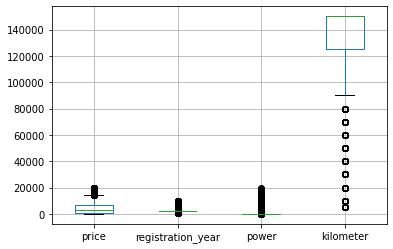

In [11]:
data_filtered.boxplot()

Выявлены аномальные выбросы в нескольких столбцах, а именно: `Price` (минимальное значение столбца = 0), `RegistrationYear` и `Power`. Пробег может быть разный и этот столбец не стоит обрабатывать. Детально изучим каждый из интересующих нас столбцов.

Чтобы выявить аномилии в данных года регистрации авто, изучим столбец `DateCrawled` из генеральной выборки. Отсортировав его по возрастанию и рассмотрев первые и последние даты можно будет понять, в каком временном промежутке скачаны все анкеты.

In [12]:
np.sort(data['DateCrawled'])

array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'], dtype=object)

Все анкеты ограничены 2016 годом. Следовательно, все автомобили, зарегестрированные позже 2016 стоит исключить. Так же, согласно результатам `describe` минимальный год регистрации авто - 1000 год, что, очевидно, аномалия. За нижний предел в дальнейшем возьмём 1950 год.

Итак, в целях исключения аномалий в данных необходимо:

1. Согласно столбцу `DateCrawled`генеральной выборки, все анкеты скачаны в 2016 году. Следовательно, стоит отсеять все авто, зарегестрированные после 2016. Так же предположим, что все автомобили, зарегестрированные раньше 1950г. тоже являются аномалиями;
1. В столбце с ценами следует исключить строки со значением 0, поскольку машину даром никто продавать не станет;
1. Верхним пределом показателя мощности двигателя возьмём двигатель БелАЗа 75710 с его 2330 л.с. Все авто с большим показателем исключим.

Проведём обработку данных, чтобы избавиться от выявленных аномалий и оценим долю удалённых данных:

In [13]:
data_filtered_temp = data_filtered[(data_filtered['registration_year'] > 1949) & (data_filtered['registration_year'] < 2017) &
                                  (data_filtered['price'] > 0) &
                                  (data_filtered['power'] < 2331)]

In [14]:
print('В результате исключения автомобилей с аномальными показателями будет удалено',data_filtered.shape[0] - data_filtered_temp.shape[0], 'строк, или',round(100 - (data_filtered_temp.shape[0] / data_filtered.shape[0] * 100), 2),"% генеральной выборки.\n")
print('Остаточная выборка содержит',data_filtered_temp.shape[0],'строк.')
data_filtered = data_filtered_temp
del data_filtered_temp

В результате исключения автомобилей с аномальными показателями будет удалено 22085 строк, или 7.14 % генеральной выборки.

Остаточная выборка содержит 287244 строк.


Избавиться от 7% выборки целесообразно, поскольку чем более достоверные данные мы сможем предоставить модели для обучения - тем лучше она научиться прогнозироавть. 

В ходе предобработки были:
- Заполнены пропуски;
- Преведены к правильному формату названия столбцов;
- Исключены объявления с аномальными показателями.

## Обучение моделей

Масштабируем данные и разделим выборку на обучающую и тестовую.

In [15]:
state = 0

X, y = data_filtered.drop(columns=['price']), data_filtered['price']
column_category = list(X.select_dtypes('object').columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)
 
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
X_train_1.loc[:,column_category] = \
    pd.DataFrame(encoder.fit_transform(X_train.loc[:,column_category]),
                 columns=column_category, index=X_train.index)
X_test_1.loc[:,column_category] = \
    pd.DataFrame(encoder.transform(X_test.loc[:,column_category]),
                 columns=column_category,index=X_test.index)
X_train = X_train_1
X_test = X_test_1
 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Обучающая выборка составляет',round(X_train.shape[0]/X.shape[0]*100, 2) ,"% от общей")
print('Тестовая выборка составляет',round(X_test.shape[0]/X.shape[0]*100, 2) ,"% от общей")

Обучающая выборка составляет 75.0 % от общей
Тестовая выборка составляет 25.0 % от общей


In [16]:
# Напишем функцию для оценеки среднеквадратичной ошибки, с помощью которой будем оценивать качество обученных моделей:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

### DecisionTreeRegressor
Обучим модель DecisionTreeRegressor с измерением времени обучения и предсказания:

In [17]:
%%time
model = DecisionTreeRegressor(random_state=state)
parameters = {'max_depth': range(1, 10),
              'min_samples_leaf' : range (1,5),
              'max_features' : range(1,5)
             }

dtr_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs = -1) 
dtr_cv.fit(X_train, y_train)
 
print('Наилучшие гиперпараметры для модели DecisionTreeRegressor: ', dtr_cv.best_params_)
print()
print('Показатель RMSE для указанных параметров:', round((-1*dtr_cv.best_score_) ** 0.5, 2))
print()

Наилучшие гиперпараметры для модели DecisionTreeRegressor:  {'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 4}

Показатель RMSE для указанных параметров: 2213.12

CPU times: user 46.7 s, sys: 33.5 ms, total: 46.8 s
Wall time: 46.8 s


In [18]:
model = DecisionTreeRegressor(random_state=state, max_depth= 9, max_features= 4, min_samples_leaf= 4)

In [19]:
%%time
model.fit(X_train, y_train)

CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 162 ms


DecisionTreeRegressor(max_depth=9, max_features=4, min_samples_leaf=4,
                      random_state=0)

In [20]:
%%time
dtr_predictions = model.predict(X_train)

CPU times: user 20.2 ms, sys: 48 µs, total: 20.3 ms
Wall time: 19.4 ms


In [21]:
dtr_rmse = round(rmse(y_train, dtr_predictions),2)
print('Показатель RMSE для предсказаний:', dtr_rmse)

Показатель RMSE для предсказаний: 2147.4


**Модель DecisionTreeRegressor** обучилась и сделала предсказание менее чем за минуту, и **показала достаточную точность,** чтобы использовать её для предсказания.

### CatBoostRegressor

Обучим модель CBR с измерением времени обучения и предсказания при изменении гиперпараметров `iterations` и `learning_rate`:

In [22]:
%%time
start_time = time.time()
model = CatBoostRegressor(verbose=10, random_state=0)

parameters = {'depth'          : [4, 6, 8],
               'iterations'    : [10,30,50,70]
              }

cbr_cv = GridSearchCV(estimator=model, param_grid = parameters, scoring='neg_mean_squared_error', cv = 2, n_jobs=-1)
cbr_cv.fit(X_train, y_train)

print("\n Показатель RMSE для указанных параметров:", round((-1*cbr_cv.best_score_) ** 0.5, 2))

print("\n Наилучшие гиперпараметры для модели:", cbr_cv.best_params_)
end_time = time.time()
sh_time = (end_time - start_time) / 60

Learning rate set to 0.5
0:	learn: 3459.1685353	total: 61.2ms	remaining: 551ms
9:	learn: 2206.1280931	total: 162ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3424.8900028	total: 11.3ms	remaining: 101ms
9:	learn: 2184.6388816	total: 103ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3459.1685353	total: 11ms	remaining: 319ms
10:	learn: 2185.0282260	total: 117ms	remaining: 202ms
20:	learn: 2014.4293927	total: 223ms	remaining: 95.6ms
29:	learn: 1942.8817531	total: 314ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3424.8900028	total: 11.7ms	remaining: 340ms
10:	learn: 2167.6080511	total: 126ms	remaining: 218ms
20:	learn: 2018.6424996	total: 234ms	remaining: 100ms
29:	learn: 1946.3440842	total: 332ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3459.1685353	total: 11ms	remaining: 540ms
10:	learn: 2185.0282260	total: 114ms	remaining: 405ms
20:	learn: 2014.4293927	total: 216ms	remaining: 299ms
30:	learn: 1936.9034737	total: 319ms	remaining: 196ms
40:	learn: 1886.2918278	

In [23]:
model = CatBoostRegressor(depth=8, iterations=70, random_state=state, verbose=False)

In [24]:
%%time
model.fit(X_train, y_train)

CPU times: user 2.41 s, sys: 11.9 ms, total: 2.42 s
Wall time: 3.22 s


In [25]:
%%time
cbr_predictions = model.predict(X_train)

CPU times: user 55.4 ms, sys: 36 µs, total: 55.4 ms
Wall time: 53.2 ms


In [26]:
cbr_rmse = round(rmse(y_train, cbr_predictions),2)
print('Показатель RMSE для предсказаний:', cbr_rmse)

Показатель RMSE для предсказаний: 1652.51


Обучение модели заняло 3 секунды, предсказание - 33 мс. Показатель RMSE менее 2500. **Модель CatBoostRegressor проходит по условию задачи.** Обучим последню модель, LightBGM.

### LightBGM

При обучении изменим гиперпараметры `num_leaves` и `learning_rate`:

In [27]:
%%time
start_time = time.time()
model = LGBMRegressor(verbose=0)

parameters = {'num_leaves'     : [20, 30, 40],
              'learning_rate'  : [0.1, 0.2, 0.3]
              }

lbgm_cv = GridSearchCV(estimator=model, param_grid = parameters, scoring='neg_mean_squared_error', cv = 2, n_jobs=-1)
lbgm_cv.fit(X_train, y_train)

print("\n Показатель RMSE для указанных параметров:", round((-1*lbgm_cv.best_score_) ** 0.5, 2))

print("\n Наилучшие гиперпараметры для модели:", lbgm_cv.best_params_)
end_time = time.time()
sh_time = (end_time - start_time) / 60

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remo

In [28]:
model = LGBMRegressor(learning_rate=0.3, num_leaves=40, random_state=state, verbose=0)

In [29]:
%%time
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293028 seconds.
You can set `force_col_wise=true` to remove the overhead.
CPU times: user 49.6 s, sys: 312 ms, total: 49.9 s
Wall time: 59.9 s


LGBMRegressor(learning_rate=0.3, num_leaves=40, random_state=0, verbose=0)

In [30]:
%%time
lbgm_predictions = model.predict(X_train)

CPU times: user 1.18 s, sys: 3 ms, total: 1.18 s
Wall time: 1.3 s


In [31]:
lbgm_rmse = round(rmse(y_train, lbgm_predictions),2)
print('Показатель RMSE для предсказаний:', lbgm_rmse)

Показатель RMSE для предсказаний: 1595.91


RMSE модели LBGM оказалсось ещё ниже, чем у CatBoost, однако время обучения и предсказания модели оказалось не выдающимися. Сделаем сводную таблицу для подведения итогов:

In [32]:
models = [['DTR', 0.185, 19, dtr_rmse], ['CBR', 3, 37, cbr_rmse], ['LGBM', 5, 1300, lbgm_rmse]] 
    
results = pd.DataFrame(models, columns = ['model', 'train_time, sec', 'prediction_time, msec', 'rmse']) 
results.set_index('model')
results

,model,"train_time, sec","prediction_time, msec",rmse
0,DTR,0.185,19,2147.40
1,CBR,3.000,37,1652.51
2,LGBM,5.000,1300,1595.91


Выявлена прямая зависимость между длительностью обучения модели и точности предсказания. Хотя по параметрам скорости лидирует модель DecisionTreeRegressor, считаю оптимальной для проверки на тестовой выборке модель CatBoostRegressor, т.к. она обладает значитльно меньшей квадратичной ошибкой, чем DTR, и работает гораздо быстрее модели LGBM.

## Анализ моделей
Сделаем предсказание моделью CatBoostRegressor на тестовой выборке.

In [33]:
model = CatBoostRegressor(depth=8, iterations=70, random_state=state, verbose=False)
model.fit(X_train, y_train)

In [34]:
%%time
cbr_predictions = model.predict(X_test)

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 36.3 ms


In [35]:
cbr_rmse = round(rmse(y_test, cbr_predictions),2)
print('Показатель RMSE для предсказаний:', cbr_rmse)

Показатель RMSE для предсказаний: 1714.98


На тестовой выборке модель CatBoostRegressor сделала предсказание за 68 мс с точностью 1546.74 евро.
## Выводы
В ходе работы:
- Была произведена предобработка данных: удалены аномалии, пропуски и названия столбцов сведены к правильному формату. 
- Подобраны наилучшие гиперпараметры для 3 моделей: DecisionTreeRegressor, CatBoostRegressor и LGBMRegressor.
- С помощью оценки метрики RMSE и скорости работы каддой модели была выбрана лучшая, плодходящая под условие задачи, модель CatBoostRegressor.
- По результатам тестовой проверки модели с гиперпараметрами `depth= 8, iterations= 70` модель обучилась за 10 секунд и сделала предсказание со среднеквадратичной ошибкой эквивалентной 1546.74 евро за 68 мс.